<a href="https://colab.research.google.com/github/dots13/fake_news_detection_Salvador/blob/master/MDFEND/MDFEND_rrss_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q transformers einops accelerate langchain bitsandbytes
!pip install faknow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 665.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 3.2 MB/s eta 0:00:00


In [3]:
import torch
from torch import Tensor
from torch import nn
from transformers import BertModel

from faknow.model.layers.layer import TextCNNLayer
from faknow.model.model import AbstractModel

from faknow.data.dataset.text import TextDataset
from faknow.data.process.text_process import TokenizerFromPreTrained
from faknow.evaluate.evaluator import Evaluator
import torch
from torch.utils.data import DataLoader

In [4]:
import joblib
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
import re

In [5]:
from google.colab import drive
import pandas as pd
from faknow.model.content_based.mdfend import MDFEND

In [55]:
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/files'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
max_len, bert = 120, 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = TokenizerFromPreTrained(max_len, bert)

domain_num = 11

In [57]:
MODEL_SAVE_PATH = 'gdrive/MyDrive/Model_step_5_epoch_20_best.pth'
MDFEND_MODEL = MDFEND(bert, domain_num)
MDFEND_MODEL.load_state_dict(torch.load(f=MODEL_SAVE_PATH , map_location=torch.device('cpu')))

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [58]:
MDFEND_MODEL.eval()

MDFEND(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

Validation Data Set

In [59]:
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem import SnowballStemmer

import re

In [60]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
path = '/content/gdrive/My Drive/files'
df_rrss = pd.read_csv(path + '/fake_news_rrss_el_salvador.csv')
df_rrss.head()

,title,url,text,author,source,topic,date,verification source,label
0,NaN,https://twitter.com/CONANCASTRO2/status/173022...,"En la escala de prioridades, lamentablemente, ...",@CONANCASTRO2,X,Politica,2023-11-30,https://vozpublica.net/2023/12/04/este-gobiern...,Fake
1,NaN,https://www.facebook.com/100064662765003/posts...,Bukele pide que los médicos que realicen ciru...,https://www.facebook.com/VentanaComunitaria,Ventana Comunitaria,Politica,2024-01-13,https://verifica.efe.com/bukele-no-pidio-carce...,Fake
2,NaN,https://twitter.com/RNacional_News/status/1745...,Bukele pide que los médicos que realicen cirug...,@RNacional_News,R Nacional News,Politica,2024-01-12,https://verifica.efe.com/bukele-no-pidio-carce...,Fake
3,NaN,https://twitter.com/nayibbukele/status/1716204...,"En El Salvador, a diferencia de la mayoría de ...",@nayibbukele,Nayib Bukele,Social,2023-10-22,https://vozpublica.net/2023/10/24/es-falso-lo-...,Fake
4,"#ClasePolítica | Candidato del FMLN, ‘El Chino...","Última Hora en X: ""#ClasePolítica | Candidato ...",Chino flores pierde el control en entrevista e...,Ultima Hora,Twiter,Politics,2024-01-17,Candidato salvadoreño Manuel Flores criticó a ...,Fake


In [63]:
def preprocess_text(text, flag=True):
    if flag:
      text = re.sub(r'[^a-zA-ZáéíóúüÁÉÍÓÚÜÑñ\s]', '', text)
      # Tokenize text
      tokens = word_tokenize(text)
      # Remove punctuation and convert to lowercase
      tokens = [token.lower() for token in tokens if token not in string.punctuation]
      # Remove stopwords
      stop_words = set(stopwords.words('spanish'))
      tokens = [token for token in tokens if token not in stop_words]
      # Stemming
      stemmer = SnowballStemmer('spanish')
      tokens = [stemmer.stem(token) for token in tokens]
    else:
      tokens = word_tokenize(text)
    return tokens

In [64]:
# return a topic number that was given by LDA
def label_document(text, flag=True):
    tokens = preprocess_text(text, flag=True)
    bow = dictionary.doc2bow(tokens)
    topic_distribution = lda_model.get_document_topics(bow)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return dominant_topic

In [65]:
def eval_report(y_test, y_pred):
    print(f'Accuracy score:{metrics.accuracy_score(y_test, y_pred):.4f}')
    print(f'Balanced accuracy score:{metrics.balanced_accuracy_score(y_test, y_pred):.4f}')
    print(f'F-1 score:{metrics.f1_score(y_test, y_pred):.4f}')
    print(f'ROC-AUC score:{metrics.roc_auc_score(y_test, y_pred):.4f}')

In [66]:
### Function for confusion matrix visualization
def confusion_matrix_visualization(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value:.0f}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    fig.show()

In [67]:
model_filename = 'gdrive/MyDrive/LDA/lda_model.pkl'
dictionary_filename = 'gdrive/MyDrive/LDA/dictionary.pkl'

lda_model = joblib.load(model_filename)
dictionary = joblib.load(dictionary_filename)


In [68]:
df_rrss['topic_new_clean'] = df_rrss['text'].apply(label_document)
df_rrss['topic_new'] = df_rrss.apply(lambda row: label_document(row['text'], False), axis=1)

In [69]:
# Make sure the labels are the same.
len(df_rrss[df_rrss.topic_new != df_rrss.topic_new_clean])

0

In [70]:
df_rrss.text[16]

'Todos los proyectos que hemos logrado, la oposición siempre votó en contra. \r\n\r\nMe alegra mucho ver como hemos pasado de ser uno de los países mas violentos del mundo, a ser vistos como un referente regional. '

In [71]:
def predict_with_bert(df, text_column, tokenizer, model):
    input_ids = []
    attention_masks = []
    for text in df[text_column]:
        encoded_text = tokenizer(text)
        input_ids.append(encoded_text['token_id'])
        attention_masks.append(encoded_text['mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    domain_tensor = torch.tensor(df_rrss.topic_new_clean.values)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_masks, domain_tensor)

    # Add predicted labels to DataFrame
    df['predicted_label'] = outputs

    return df

In [72]:
predict_with_bert(df_rrss, 'text', tokenizer, MDFEND_MODEL)

,title,url,text,author,source,topic,date,verification source,label,topic_new_clean,topic_new,predicted_label
0,NaN,https://twitter.com/CONANCASTRO2/status/173022...,"En la escala de prioridades, lamentablemente, ...",@CONANCASTRO2,X,Politica,2023-11-30,https://vozpublica.net/2023/12/04/este-gobiern...,Fake,2,2,0.123051
1,NaN,https://www.facebook.com/100064662765003/posts...,Bukele pide que los médicos que realicen ciru...,https://www.facebook.com/VentanaComunitaria,Ventana Comunitaria,Politica,2024-01-13,https://verifica.efe.com/bukele-no-pidio-carce...,Fake,10,10,0.981155
2,NaN,https://twitter.com/RNacional_News/status/1745...,Bukele pide que los médicos que realicen cirug...,@RNacional_News,R Nacional News,Politica,2024-01-12,https://verifica.efe.com/bukele-no-pidio-carce...,Fake,8,8,0.460388
3,NaN,https://twitter.com/nayibbukele/status/1716204...,"En El Salvador, a diferencia de la mayoría de ...",@nayibbukele,Nayib Bukele,Social,2023-10-22,https://vozpublica.net/2023/10/24/es-falso-lo-...,Fake,8,8,0.258123
4,"#ClasePolítica | Candidato del FMLN, ‘El Chino...","Última Hora en X: ""#ClasePolítica | Candidato ...",Chino flores pierde el control en entrevista e...,Ultima Hora,Twiter,Politics,2024-01-17,Candidato salvadoreño Manuel Flores criticó a ...,Fake,2,2,0.618334
5,NaN,https://www.instagram.com/p/C2PzqBNONx5/?img_i...,"El candidato presidencial del FMLN, Manuel «El...",@elblogcom,Instagram,Politics,2024-01-18,https://factual.afp.com/doc.afp.com.34HE73G,Fake,2,2,0.974693
6,NaN,https://twitter.com/JavierFlorB/status/1684343...,Se viene una alianza basada en huevos bien ray...,@JavierFlorB,X,Politics,2023-07-26,https://factual.afp.com/doc.afp.com.33QM3P8,Fake,2,2,0.987204
7,NaN,https://twitter.com/ARMANDO23539037/status/152...,LINDO MI CHOLO CARAJO!! El Presidente Bukele ...,@ARMANDO23539037,X,Politics,2022-05-03,https://verifica.efe.com/bukele-no-decreto-seg...,Fake,8,8,0.999985
8,NaN,https://www.facebook.com/asieslavainanoticias/...,Presidente Bukele ordena quitar seguridad a Di...,Asi es la vaina,Facebook,Politics,2022-12-04,https://verifica.efe.com/bukele-no-decreto-seg...,Fake,2,2,0.168808
9,NaN,https://www.facebook.com/jfsalmon.campos/posts...,"EL SALVADOR SE RETIRA DE LA O.E.A., LO DIJO EL...",Jorge Fernando Salmón Campos,Facebook,Politics,2022-10-22,https://verifica.efe.com/salvador-oea-sigue-pe...,Fake,3,3,0.999694


In [73]:
dic_label = {'Fake': 1, 'Real': 0}
df_rrss['labels_0_1'] = df_rrss['predicted_label'].apply(lambda x: 1 if x >= 0.5 else 0)

In [74]:
df_rrss['label'] = df_rrss.label.map(dic_label)

<Axes: >

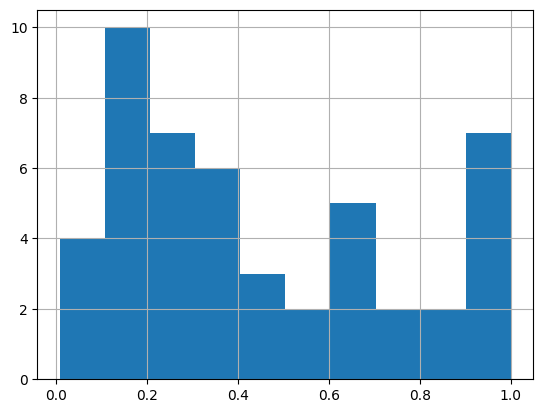

In [75]:
df_rrss.predicted_label.hist()

In [76]:
df_rrss

,title,url,text,author,source,topic,date,verification source,label,topic_new_clean,topic_new,predicted_label,labels_0_1
0,NaN,https://twitter.com/CONANCASTRO2/status/173022...,"En la escala de prioridades, lamentablemente, ...",@CONANCASTRO2,X,Politica,2023-11-30,https://vozpublica.net/2023/12/04/este-gobiern...,1,2,2,0.123051,0
1,NaN,https://www.facebook.com/100064662765003/posts...,Bukele pide que los médicos que realicen ciru...,https://www.facebook.com/VentanaComunitaria,Ventana Comunitaria,Politica,2024-01-13,https://verifica.efe.com/bukele-no-pidio-carce...,1,10,10,0.981155,1
2,NaN,https://twitter.com/RNacional_News/status/1745...,Bukele pide que los médicos que realicen cirug...,@RNacional_News,R Nacional News,Politica,2024-01-12,https://verifica.efe.com/bukele-no-pidio-carce...,1,8,8,0.460388,0
3,NaN,https://twitter.com/nayibbukele/status/1716204...,"En El Salvador, a diferencia de la mayoría de ...",@nayibbukele,Nayib Bukele,Social,2023-10-22,https://vozpublica.net/2023/10/24/es-falso-lo-...,1,8,8,0.258123,0
4,"#ClasePolítica | Candidato del FMLN, ‘El Chino...","Última Hora en X: ""#ClasePolítica | Candidato ...",Chino flores pierde el control en entrevista e...,Ultima Hora,Twiter,Politics,2024-01-17,Candidato salvadoreño Manuel Flores criticó a ...,1,2,2,0.618334,1
5,NaN,https://www.instagram.com/p/C2PzqBNONx5/?img_i...,"El candidato presidencial del FMLN, Manuel «El...",@elblogcom,Instagram,Politics,2024-01-18,https://factual.afp.com/doc.afp.com.34HE73G,1,2,2,0.974693,1
6,NaN,https://twitter.com/JavierFlorB/status/1684343...,Se viene una alianza basada en huevos bien ray...,@JavierFlorB,X,Politics,2023-07-26,https://factual.afp.com/doc.afp.com.33QM3P8,1,2,2,0.987204,1
7,NaN,https://twitter.com/ARMANDO23539037/status/152...,LINDO MI CHOLO CARAJO!! El Presidente Bukele ...,@ARMANDO23539037,X,Politics,2022-05-03,https://verifica.efe.com/bukele-no-decreto-seg...,1,8,8,0.999985,1
8,NaN,https://www.facebook.com/asieslavainanoticias/...,Presidente Bukele ordena quitar seguridad a Di...,Asi es la vaina,Facebook,Politics,2022-12-04,https://verifica.efe.com/bukele-no-decreto-seg...,1,2,2,0.168808,0
9,NaN,https://www.facebook.com/jfsalmon.campos/posts...,"EL SALVADOR SE RETIRA DE LA O.E.A., LO DIJO EL...",Jorge Fernando Salmón Campos,Facebook,Politics,2022-10-22,https://verifica.efe.com/salvador-oea-sigue-pe...,1,3,3,0.999694,1


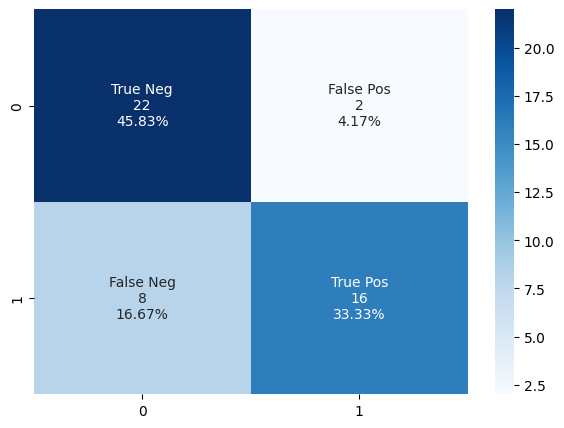

In [77]:
y_test, pred = df_rrss['label'], df_rrss['labels_0_1']
cm = confusion_matrix(y_test, pred)

confusion_matrix_visualization(cm)

In [78]:
eval_report(y_test, pred)

Accuracy score:0.7917
Balanced accuracy score:0.7917
F-1 score:0.7619
ROC-AUC score:0.7917


In [79]:
df_rrss[df_rrss.label != df_rrss.labels_0_1][['label', 'predicted_label', 'labels_0_1']]

,label,predicted_label,labels_0_1
0,1,0.123051,0
2,1,0.460388,0
3,1,0.258123,0
8,1,0.168808,0
17,1,0.193573,0
21,1,0.258123,0
22,1,0.241881,0
23,1,0.287046,0
24,0,0.791866,1
42,0,0.678261,1


In [80]:
df_rrss[['label', 'predicted_label', 'labels_0_1']]

,label,predicted_label,labels_0_1
0,1,0.123051,0
1,1,0.981155,1
2,1,0.460388,0
3,1,0.258123,0
4,1,0.618334,1
5,1,0.974693,1
6,1,0.987204,1
7,1,0.999985,1
8,1,0.168808,0
9,1,0.999694,1


In [81]:
# One text test

In [82]:
df_rrss.iloc[20]['text']

'y lo que hemos hecho es una cosa simple\r\ny sencilla resolver un caso que se nos\r\nplantea y ahí está se resolvió la\r\ninscripción favorable con cuatro votos a\r\nfavor y con una abstención\r\nEh Pues es lo normal dentro de un\r\ntribunal y en un organismo colegiado eh\r\nla inscripción\r\neh está dentro los parámetros legales\r\nestá con todas las de la ley no sé por\r\nqué ser algo novedoso lo que sí es\r\ncierto es que este organismo colegiado\r\nha actuado conforme a la ley\r\n'

In [83]:
text = df_rrss.iloc[20]['text']
domain_num = df_rrss.iloc[20]['topic_new']

In [84]:
token = tokenizer(text)
tensor_domain = torch.tensor(domain_num)

In [85]:
tensor_domain

tensor(2)

In [86]:
for i in range(20):
  pred = MDFEND_MODEL(token['token_id'], token['mask'], tensor_domain)
  print(f'{i}: {pred}')

0: tensor([0.5245], grad_fn=<SigmoidBackward0>)
1: tensor([0.5245], grad_fn=<SigmoidBackward0>)
2: tensor([0.5245], grad_fn=<SigmoidBackward0>)
3: tensor([0.5245], grad_fn=<SigmoidBackward0>)
4: tensor([0.5245], grad_fn=<SigmoidBackward0>)
5: tensor([0.5245], grad_fn=<SigmoidBackward0>)
6: tensor([0.5245], grad_fn=<SigmoidBackward0>)
7: tensor([0.5245], grad_fn=<SigmoidBackward0>)
8: tensor([0.5245], grad_fn=<SigmoidBackward0>)
9: tensor([0.5245], grad_fn=<SigmoidBackward0>)
10: tensor([0.5245], grad_fn=<SigmoidBackward0>)
11: tensor([0.5245], grad_fn=<SigmoidBackward0>)
12: tensor([0.5245], grad_fn=<SigmoidBackward0>)
13: tensor([0.5245], grad_fn=<SigmoidBackward0>)
14: tensor([0.5245], grad_fn=<SigmoidBackward0>)
15: tensor([0.5245], grad_fn=<SigmoidBackward0>)
16: tensor([0.5245], grad_fn=<SigmoidBackward0>)
17: tensor([0.5245], grad_fn=<SigmoidBackward0>)
18: tensor([0.5245], grad_fn=<SigmoidBackward0>)
19: tensor([0.5245], grad_fn=<SigmoidBackward0>)


In [87]:
# Same sample, different domains

In [88]:
for i in range(11):
  pred = MDFEND_MODEL(token['token_id'], token['mask'], torch.tensor(i)).item()
  print(f'for domain {i} prebability is: {pred:.3f}')

for domain 0 prebability is: 0.524
for domain 1 prebability is: 0.524
for domain 2 prebability is: 0.524
for domain 3 prebability is: 0.524
for domain 4 prebability is: 0.524
for domain 5 prebability is: 0.524
for domain 6 prebability is: 0.524
for domain 7 prebability is: 0.524
for domain 8 prebability is: 0.524
for domain 9 prebability is: 0.524
for domain 10 prebability is: 0.524


In [89]:
### Extra sample

In [90]:
text = '''El Tribunal Supremo Electoral (TSE) publicó hoy el acta de escrutinio de los 44 concejos municipales
que se instalarán a partir de mayo de 2024 y los 40 diputados propietarios y suplentes del
Parlamento Centroamericano (Parlacen) que se instalarán en 2026. En el acta, los magistrados
explicaron que, para la distribución de concejales, no aplicaron la regla normada en el artículo 219
del Código Electoral que “no permite al partido ganador participar en la distribución de regidores y
regidoras por residuo”, una regla que también fue omitida en las elecciones de 2021. El magistrado
Julio Olivo aseguró, según el acta, que la inaplicación del artículo c del artículo 219 del Código
Electoral “rompe con la losofía de integración pluralista de los concejos municipales que se
conforman con un sistema mixto de reparto mayoritario y proporcional”. Olivo manifestó que no
existe licencia para inobservar el literal del artículo 2019 ni para interpretar cuando una norma es
clara. El magistrado Rubén Meléndez bajo esta nueva regla, el TSE concluyó que “se potencia el
residuo mayor en perjuicio del residuo menor” ya que se considera “más apegado a la realidad”, por
lo que consideró que “hay un mayor respeto de la voluntad del elector”. Meléndez indicó que la
aplicación de artículo 219 permitiendo al ganador participar en la distribución de regidores por
residuo fue sometido a conocimiento de la Sala de lo Constitucional y las demandas de amparo
fueron sobreseídas (154-2021) porque el “TSE es la autoridad competente para interpretar y aplicar
la legislación electoral secundaria”.'''

In [91]:
label = label_document(text)

In [92]:
encoded_text = tokenizer(text)
token_id = encoded_text['token_id']
attention_masks = encoded_text['mask']
domain_tensor = torch.tensor(label)

MDFEND_MODEL(token_id, attention_masks, domain_tensor)

tensor([0.6192], grad_fn=<SigmoidBackward0>)

In [93]:
encoded_text = tokenizer(text)
token_id = encoded_text['token_id']
attention_masks = encoded_text['mask']

In [95]:
text_2 = '''Habla la Constitución de la República: “Art. 92.- Puede adquirir la calidad de salvadoreños por
naturalización: 1º.- Los españoles e hispanoamericanos de origen que tuvieren un año de
residencia en el país; 2º.- Los extranjeros de cualquier origen que tuvieren cinco años de
residencia en el país; 3º.- Los que por servicios notables prestados a la República obtengan esa
calidad del Órgano Legislativo; 4º.- El extranjero casado con salvadoreña o la extranjera casada
con salvadoreño que acreditaren dos años de residencia en el país, anteriores o posteriores a la
celebración del matrimonio. La nacionalidad por naturalización se otorgará por autoridades
competentes de conformidad con la ley”. El presidente Bukele ofreció 5,000 pasaportes gratis,
la ciudadanía plena y facilidades para reubicación familiar para profesionales extranjeros
“cualificados” que se vengan al país. Sin embargo, explican constitucionalistas, la Constitución
habla de conceder la nacionalidad salvadoreña por “servicios notables prestados a la
República”, en tiempo pasado, es decir, méritos ya logrados, no a futuro. Por tanto, pretender
nacionalizar extranjeros que no han hecho méritos ni prestado servicios a la República no
cumple con la Constitución. Para el juez y profesor de Derecho, Antonio Durán, “no se puede
regalar (nacionalidad) así por así para el extranjero que no es centroamericano de origen”.
Durán recalcó que “la nacionalidad honorífica es por servicios prestados al país, no por
servicios por prestarse. Es un reconocimiento a los méritos que alguien ha hecho, no es que
van a regalar la nacionalidad, al menos constitucionalmente no sería aceptable, pero como se
hace lo que él dice aún contra la Constitución”. Pero el juez sostuvo que cualquier reforma
aplicada a la Ley de Extranjería tendría que cumplir con los requisitos que la Constitución
indica. En 2023 se hizo reforma a la Ley de Migración en el artículo 156, donde señala que los
extranjeros podrán solicitar la nacionalidad salvadoreña por naturalización. Según el numeral 5,
quien cumpla con los requisitos establecidos en programas gubernamentales destinados a la
atracción de inversión o donantes será un candidato viable y la Dirección General de Migración
y Extranjería será encargada de tramitar dicho procedimiento. Pero eso es diferente a lo que
ahora se plantea y que, para el juez Durán, “es un acto demagógico”. “Lo veo dentro del
contexto de la propaganda y la publicidad del bombardeo mediático a nivel internacional del
presidente, es un acto para mi juicio demagógico”, subrayó. Se subestima a los profesionales
salvadoreños Este juez de carrera explicó que si se ven los salarios que tienen los médicos en el
sector de salud pública, ofertas laborales que han salido hace algunos meses para un
neurólogo, pediatra, de $600 dólares (...) “el menosprecio que hay hacia la hacia los
profesionales es tremendo. Entonces, ¿cómo se va a venir un médico de Europa, Estados
Unidos o de otros lados a prestar sus servicios en estas condiciones?”, se pregunta.
Inicialmente el anuncio del mandatario está dirigido a científicos, ingenieros, médicos, artistas y
filósofos, sin brindar detalles sobre las posibles ofertas laborales que estás personas podrían
llegar a ocupar en el territorio salvadoreño. Sindicalistas del sector salud en reiteradas
ocasiones han denunciado las condiciones en las que se encuentra funcionando la red de
hospitales a nivel nacional entre la falta de insumos y la constante fuga de especialistas al
sector privado en búsqueda de mejores ofertas laborales. El juez Durán sostiene que esta
acción carece de planificación y podría quedar sin ponerse en marcha al igual que “el satélite
Cuscatlán”, la extracción de petróleo, energía nuclear, entre otros anuncios. “Yo insisto: esto es
publicidad y va a ser tan fructífero como el hallazgo del petróleo o de la explotación de la
energía volcánica”, vaticinó. Por su parte un exmagistrado constitucionalista, que pidió reserva
de su nombre, sostuvo que “ese anuncio es ambiguo, no hay claridad en las formas de cómo lo
va a hacer”, pues inclusive está ofreciendo el derecho al voto '''

In [96]:
label_2 = label_document(text_2)

In [97]:
encoded_text = tokenizer(text_2)
token_id = encoded_text['token_id']
attention_masks = encoded_text['mask']
domain_tensor = torch.tensor(label_2)

MDFEND_MODEL(token_id, attention_masks, domain_tensor)

tensor([0.1507], grad_fn=<SigmoidBackward0>)